# Libraries

In [1]:
import pandas as pd
import numpy as np
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
import mplcursors
%matplotlib widget

[nltk_data] Downloading package punkt to /home/a2211506/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# !wget "https://aclanthology.org/anthology+abstracts.bib.gz" -O anthology_abstracts.bib.gz

In [3]:
# !gzip -d anthology_abstracts.bib.gz

# Preprocessing
## BibTexの形式について
### ENTRYTYPEについて
`anthology_abstracts`には`ENTRYTYPE`の取りうる値に`proceedings`と`inproceedings`の2つが存在する。　　
- `proceedings`: 議事録(アブストラクトが存在しない)　　
- `inproceedings`: 論文(アブストラクトが存在する)　　
したがって、アブストラクトを得るためには、`ENTRYTYPE`が`inproceedings`のものを取得する。　　
### Abstractについて
- 現在から2017年まではAbstractが存在する

In [4]:
# !head anthology_abstracts.bib -n 51209  > anthology_abstracts_2022.bib

In [5]:
# with open("anthology_abstracts_2022.bib") as f:
#     s = f.read()

In [6]:
# s = s.replace("apr", '"apr"').replace("may", '"may"').replace("jun", '"jun"').replace("jul", '"jul"').replace("aug", '"aug"').replace("sep", '"sep"').replace("oct", '"oct"').replace("nov", '"nov"').replace("dec", '"dec"').replace("jan", '"jan"').replace("feb", '"feb"').replace("mar", '"mar"')
# with open("anthology_abstracts_2022_modified.bib", mode='w') as f:
#     f.write(s)

In [7]:
# # https://bibtexparser.readthedocs.io/en/master/
# import bibtexparser
# with open('anthology_abstracts_2022_modified.bib') as bibtex_file:
#     bib_database = bibtexparser.load(bibtex_file)

In [8]:
# bib_database.entries[0]

In [9]:
# with open("anthology_abstracts_modified2022.bib.pkl","wb") as f:
#     pickle.dump(bib_database, f)

In [10]:
# !chmod 555 anthology_abstracts_modified2022.bib.pkl

In [11]:
with open("anthology_abstracts_modified2022.bib.pkl", "rb") as f:
    anthology2022 = pickle.load(f)

In [12]:
anthology2022_pd = (pd.DataFrame(anthology2022.entries))
anthology2022_pd = anthology2022_pd[(anthology2022_pd["ENTRYTYPE"]  == "inproceedings") & (anthology2022_pd["publisher"] == "Association for Computational Linguistics")] 
title_list = anthology2022_pd['title'].values
anthology2022_pd.iloc[0:3]

,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,abstract,pages,doi,booktitle,author,language,volume,journal,number
1,https://aclanthology.org/2022.wordplay-1.1,Association for Computational Linguistics,"Seattle, United States",2022,jul,NaN,A Systematic Survey of Text Worlds as Embodied...,inproceedings,"""jan""sen-2022-systematic",Text Worlds are virtual environments for embod...,1--15,10.18653/v1/2022.wordplay-1.1,Proceedings of the 3rd Wordplay: When Language...,"Jansen, Peter",NaN,NaN,NaN,NaN
2,https://aclanthology.org/2022.wordplay-1.2,Association for Computational Linguistics,"Seattle, United States",2022,jul,NaN,A Minimal Computational Improviser Based on Or...,inproceedings,montfort-bartlett-fernandez-2022-minimal,A prototype system for playing a minimal impro...,16--24,10.18653/v1/2022.wordplay-1.2,Proceedings of the 3rd Wordplay: When Language...,"Montfort, Nick and\nBartlett Fernandez, Sebas...",NaN,NaN,NaN,NaN
4,https://aclanthology.org/2022.woah-1.2,Association for Computational Linguistics,"Seattle, Washington (Hybrid)",2022,jul,NaN,Towards Automatic Generation of Messages Count...,inproceedings,ashida-komachi-2022-towards,"With the widespread use of social media, onlin...",11--23,10.18653/v1/2022.woah-1.2,Proceedings of the Sixth Workshop on Online Ab...,"Ashida, Mana and\nKomachi, Mamoru",NaN,NaN,NaN,NaN


1. 年代を細切れにする(2000と2022)  
2. センテンスBERTを用いる  
PCAだけでよい  
3. タイトルからドットを探す。(ベストアワード)  
4. Kernel PCA  

In [13]:
docs = anthology2022_pd.iloc[:]["abstract"]
docs_tokenized = [(nltk.word_tokenize(str(doc))) for doc in (docs)]
docs_tokenized[0]

['Text',
 'Worlds',
 'are',
 'virtual',
 'environments',
 'for',
 'embodied',
 'agents',
 'that',
 ',',
 'unlike',
 '2D',
 'or',
 '3D',
 'environments',
 ',',
 'are',
 'rendered',
 'exclusively',
 'using',
 'textual',
 'descriptions',
 '.',
 'These',
 'environments',
 'offer',
 'an',
 'alternative',
 'to',
 'higher-fidelity',
 '3D',
 'environments',
 'due',
 'to',
 'their',
 'low',
 'barrier',
 'to',
 'entry',
 ',',
 'providing',
 'the',
 'ability',
 'to',
 'study',
 'semantics',
 ',',
 'compositional',
 'inference',
 ',',
 'and',
 'other',
 'high-level',
 'tasks',
 'with',
 'rich',
 'action',
 'spaces',
 'while',
 'controlling',
 'for',
 'perceptual',
 'input',
 '.',
 'This',
 'systematic',
 'survey',
 'outlines',
 'recent',
 'developments',
 'in',
 'tooling',
 ',',
 'environments',
 ',',
 'and',
 'agent',
 'modeling',
 'for',
 'Text',
 'Worlds',
 ',',
 'while',
 'examining',
 'recent',
 'trends',
 'in',
 'knowledge',
 'graphs',
 ',',
 'common',
 'sense',
 'reasoning',
 ',',
 'transfe

# Documents to Vectors(Doc2vec)

In [14]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_tokenized)]
model = Doc2Vec(documents, vector_size=128, window=2, min_count=1, workers=-1)

In [15]:
from gensim.test.utils import get_tmpfile
model.save("anthology2022.model")
model = Doc2Vec.load("anthology2022.model")

In [16]:
model.dv[0]

array([-4.0865745e-03, -4.6711937e-03, -7.7193398e-03,  6.6819098e-03,
        2.7860273e-03,  2.0549260e-04, -7.7192411e-03, -4.0364452e-03,
       -7.5921584e-03,  1.5709214e-03,  2.2111796e-03,  3.6277771e-03,
       -3.3572465e-03, -2.4575833e-03, -2.4053026e-03, -6.8139974e-03,
        1.6972516e-03,  7.2075166e-03, -7.4233338e-03, -2.7016308e-03,
       -2.9452424e-03,  2.0370167e-03, -4.4465289e-03,  2.0474065e-03,
        4.5332201e-03, -6.3334852e-03, -6.5076500e-03, -7.7770855e-03,
        3.8539413e-03, -7.1268026e-03,  4.5640338e-03,  5.3127054e-03,
       -5.0831251e-03, -3.5311580e-03, -9.8036043e-04,  1.2861881e-03,
       -1.1572950e-03, -6.6738613e-03, -2.8145425e-03,  1.3528317e-03,
       -1.6069692e-03, -5.6484714e-03,  3.2692179e-03, -6.6987034e-03,
        2.1183882e-03, -3.6044698e-03,  5.0424039e-04, -1.6073026e-03,
        4.2290837e-03, -6.2520094e-03, -1.6561337e-03, -7.4855983e-05,
       -5.1865447e-03, -5.0985664e-03, -1.5101247e-03,  6.8777148e-03,
      

In [17]:

data = [[(i)] + list(model.dv[i]) for i in range(len(documents))]
column_names = ["type"]+["x_"+str(dim) for dim in range(model.vector_size)]
out = pd.DataFrame(data, columns=column_names)
out = out.sort_values(["type"])
out.to_csv("anthology2022.csv", index=None)
out.insert(1, 'title', anthology2022_pd['title'].values)
out


,type,title,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,...,x_118,x_119,x_120,x_121,x_122,x_123,x_124,x_125,x_126,x_127
0,0,A Systematic Survey of Text Worlds as Embodied...,-0.004087,-0.004671,-0.007719,0.006682,0.002786,0.000205,-0.007719,-0.004036,...,0.002859,0.006326,0.006951,0.004880,-0.004874,0.006770,-0.007366,0.000554,-0.005174,-0.000625
1,1,A Minimal Computational Improviser Based on Or...,0.002063,-0.006011,0.003093,0.001115,-0.000420,0.004858,-0.003420,-0.001307,...,-0.001561,0.004814,-0.005440,-0.006790,-0.007565,-0.006261,-0.005024,-0.001805,-0.001834,0.004910
2,2,Towards Automatic Generation of Messages Count...,0.003528,0.004057,0.002054,0.001589,0.003578,0.006848,0.004164,0.001598,...,0.006334,-0.001039,0.007193,-0.006093,0.001928,0.006982,-0.007615,-0.000961,-0.006725,0.005595
3,3,{G}rease{V}ision: Rewriting the Rules of the I...,-0.001633,0.004768,-0.003725,0.002522,-0.003051,-0.007043,-0.002335,-0.000504,...,-0.000792,0.005549,0.004894,0.003550,-0.000893,0.000306,-0.006690,0.000036,-0.005288,0.006117
4,4,Improving Generalization of Hate Speech Detect...,0.005179,-0.004625,-0.001097,0.002516,-0.003448,0.006718,0.003742,0.003615,...,0.002558,-0.000880,-0.002310,0.004100,0.003550,-0.005085,0.001933,0.006109,0.006555,0.002714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,1070,Make the Best of Cross-lingual Transfer: Evide...,-0.005722,0.002103,-0.007701,0.002135,-0.007289,0.001612,0.005803,-0.003614,...,0.003627,-0.001834,0.001535,0.000083,0.002773,-0.006622,0.002796,-0.006605,-0.007042,-0.004527
1071,1071,Probing for Labeled Dependency Trees,-0.002090,-0.002597,-0.004373,-0.000471,-0.000445,-0.001005,0.006236,0.003305,...,-0.000621,0.001593,0.003777,-0.001343,-0.007143,-0.003254,-0.001195,-0.004160,0.001411,0.004836
1072,1072,Entity-based Neural Local Coherence Modeling,-0.007760,0.000028,0.005915,-0.005781,0.006367,0.006817,-0.006413,0.006042,...,0.003514,0.001793,-0.004630,-0.004634,0.003628,0.005425,0.006806,0.004284,-0.006684,-0.004202
1073,1073,{``}That Is a Suspicious Reaction!{''}: Interp...,0.007240,-0.003839,-0.004146,0.003301,-0.000444,0.004244,-0.004816,-0.001618,...,0.004821,-0.003867,0.003182,-0.004227,0.006805,-0.006103,-0.005977,0.000907,0.002096,0.005796


In [18]:
X = out.iloc[:, 2:]
pca = PCA(n_components=2)
pca.fit(X)
x_pcx = pca.transform(X)
x_pcx.shape

(1075, 2)

In [19]:
# 主成分
print(f"PCA componments shape:\n{pca.components_.shape}")

PCA componments shape:
(2, 128)


Text(0.5, 0, 'Feature')

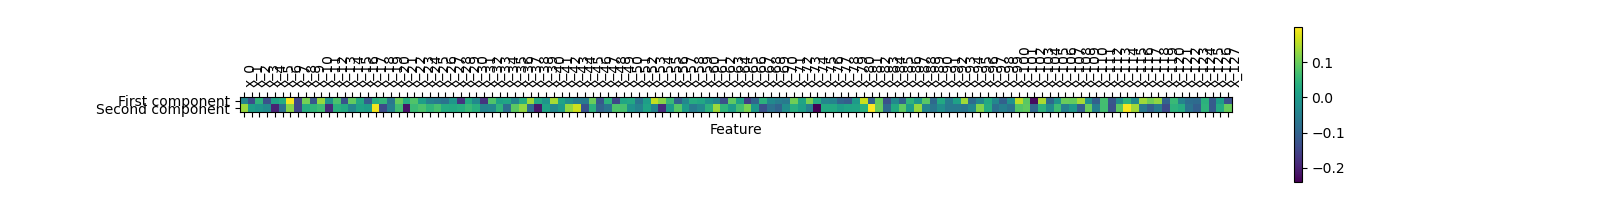

In [20]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(column_names[1:])),
           column_names[1:], rotation=90, ha='left')
plt.xlabel("Feature")

## Visualization(Mouse hover)

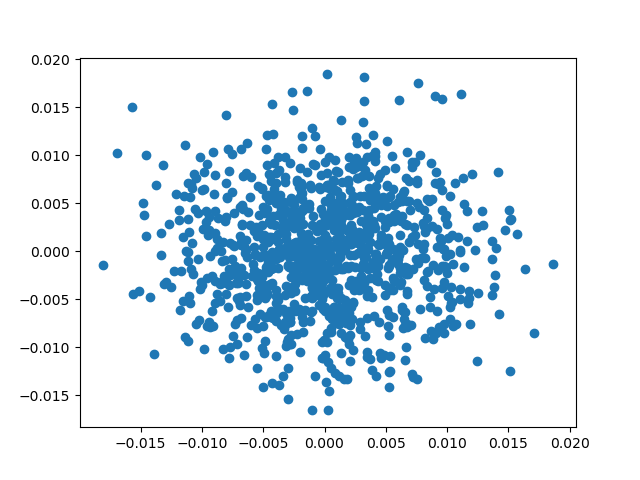

In [21]:
fig, ax = plt.subplots()
sc = ax.scatter(x_pcx[:, 0], x_pcx[:, 1])
# by default the tooltip is displayed "onclick"
# we can change it by setting hover to True
cursor = mplcursors.cursor(sc, hover=True)
# by default the annotation displays the xy positions
# this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=title_list[sel.target.index])
plt.show()

In [22]:
best_paper_awards = [['Best Paper', 'Learned Incremental Representations for Parsing'],
['Best Special Theme Paper', 'Requirements and Motivations of Low-Resource Speech Synthesis for Language Revitalization'],
['Best Resource Paper', 'DiBiMT: A Novel Benchmark for Measuring Word Sense Disambiguation Biases in Machine Translation'],
['Best Linguistic Insight Paper', 'KinyaBERT: a Morphology-aware Kinyarwanda Language Model'],
['Outstanding Papers', 'Evaluating Factuality in Text Simplification'],
['Outstanding Papers', 'Online Semantic Parsing for Latency Reduction in Task-Oriented Dialogue'],
['Outstanding Papers', 'Learning to Generalize to More: Continuous Semantic Augmentation for Neural Machine Translation'],
['Outstanding Papers', 'Fantastically Ordered Prompts and Where to Find Them: Overcoming Few-Shot Prompt Order Sensitivity'],
['Outstanding Papers', 'Inducing Positive Perspectives with Text Reframing'],
['Outstanding Papers', 'Ditch the Gold Standard: Re-evaluating Conversational Question Answering'],
['Outstanding Papers', 'Active Evaluation: Efficient NLG Evaluation with Few Pairwise Comparisons'],
['Outstanding Papers', 'Compression of Generative Pre-trained Language Models via Quantization'],
]

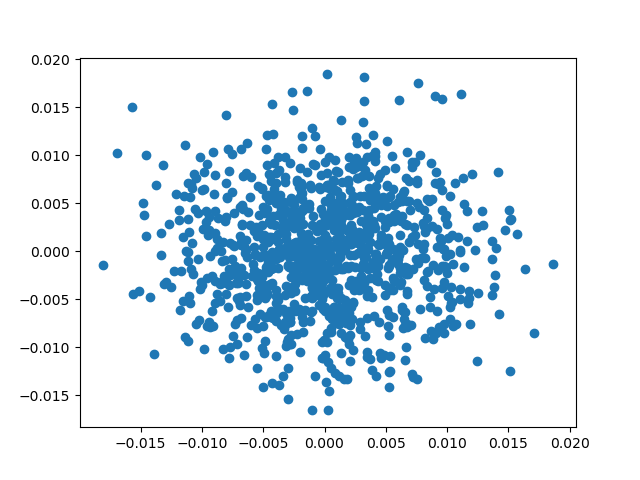

In [23]:
fig, ax = plt.subplots()
sc = ax.scatter(x_pcx[:, 0], x_pcx[:, 1])
# by default the tooltip is displayed "onclick"
# we can change it by setting hover to True
cursor = mplcursors.cursor(sc, hover=True)
# by default the annotation displays the xy positions
# this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=title_list[sel.target.index])
plt.show()

In [28]:
# # Best Paperの文書IDを取得
type_of_awarded_paper =  (out[out['title'].isin([r[1] for r in best_paper_awards])])
type_of_awarded_paper.insert(2, 'award_type', 'award_type')

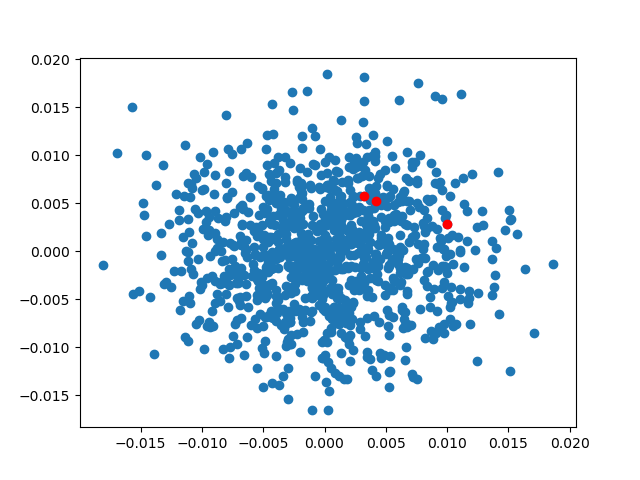

In [25]:
fig, ax = plt.subplots()
sc = []
sc.append(ax.scatter(x_pcx[:, 0], x_pcx[:, 1]))
for a_type_of_awarded_paper in type_of_awarded_paper['type']:
    sc.append(ax.scatter(x_pcx[a_type_of_awarded_paper, 0], x_pcx[a_type_of_awarded_paper, 1], c='r'))

cursor = mplcursors.cursor(sc, hover=True)
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=title_list[sel.target.index])
plt.show()

# t-SNE

In [ ]:
X = out.iloc[:, 1:]
tsne = TSNE(random_state=42) # , init='pca', learning_rate="auto"
x_tsne = tsne.fit_transform(X)
x_tsne.shape

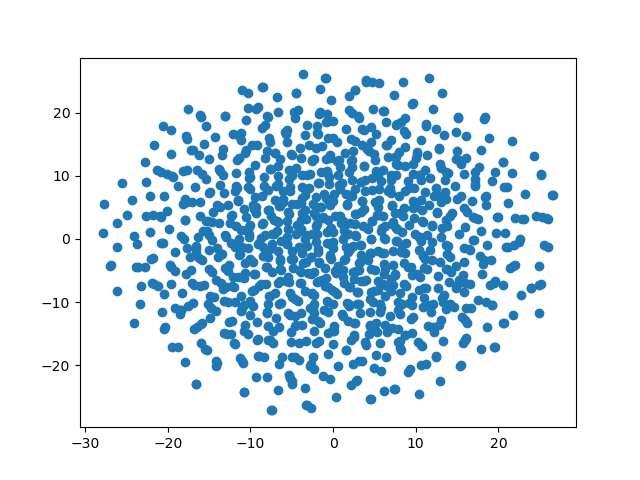

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x_tsne[:, 0], x_tsne[:, 1])
plt.show()

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(x_tsne[:, 0], x_tsne[:, 1])
# by default the tooltip is displayed "onclick"
# we can change it by setting hover to True
cursor = mplcursors.cursor(sc, hover=True)
# by default the annotation displays the xy positions
# this is to change it to the countries name
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=title_list[sel.target.index])
plt.show()